In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from orix.io import load
from orix.crystal_map import CrystalMap
from orix.quaternion import Orientation
from scipy.interpolate import griddata
import matplotlib.patches as mpatches
from extract_preprocess_ebsd import add_indices_to_dataframe, plot_phase_map_roi, mark_phase_boundaries_and_plot,compute_kam_gb_from_df,plot_kam_with_overlays

In [25]:
# -----------------------------
# 1️. Load EBSD data
# -----------------------------
fname_raw = '20min_ebsd_raw.ctf'
ebsd_raw = load(fname_raw)

In [26]:
ebsd_raw.shape

(384, 511)

In [27]:
ebsd_raw.size

196608

In [4]:
# -----------------------------
# 2. Subregion selection
# -----------------------------
region = [0, 3, 13, 7]  # x_min, y_min, width, height
x_min, y_min, width, height = region
x_max, y_max = x_min + width, y_min + height

mask = (ebsd_raw.x >= x_min) & (ebsd_raw.x <= x_max) & (ebsd_raw.y >= y_min) & (ebsd_raw.y <= y_max)
ebsd_region = ebsd_raw[mask]

In [5]:
ebsd_raw

Phase    Orientations            Name  Space group  Point group  Proper point group       Color
   -1   55867 (28.4%)     not_indexed         None         None                None           w
    1   88518 (45.0%)  Iron bcc (old)         None         m-3m                 432    tab:blue
    2     1012 (0.5%)        Iron fcc         None         m-3m                 432  tab:orange
    3     4463 (2.3%)        Hematite         None          -3m                  32   tab:green
    4   35200 (17.9%)       Magnetite         None         m-3m                 432     tab:red
    5    11548 (5.9%)        Wuestite         None         m-3m                 432  tab:purple
Properties: bands, error, MAD, BC, BS
Scan unit: um

In [80]:
ebsd_region

Phase    Orientations            Name  Space group  Point group  Proper point group       Color
   -1   40061 (30.4%)     not_indexed         None         None                None           w
    1   62581 (47.5%)  Iron bcc (old)         None         m-3m                 432    tab:blue
    2      540 (0.4%)        Iron fcc         None         m-3m                 432  tab:orange
    3     3083 (2.3%)        Hematite         None          -3m                  32   tab:green
    4   17758 (13.5%)       Magnetite         None         m-3m                 432     tab:red
    5     7647 (5.8%)        Wuestite         None         m-3m                 432  tab:purple
Properties: bands, error, MAD, BC, BS
Scan unit: um

In [6]:
fcc_mask = ebsd_region.phase_id == 2
ebsd_region.phase_id[fcc_mask] = -1

In [46]:
x_min, x_max = ebsd_region.x.min(), ebsd_region.x.max()
y_min, y_max = ebsd_region.y.min(), ebsd_region.y.max()

In [48]:
print(x_min,x_max)
print(y_min,y_max)

arry = np.unique(ebsd_raw.y)
positions = np.where(arry == 3.0212)[0]
print("Position of 30:", positions) 

0.0 12.9779
3.0212 9.983
Position of 30: [115]


In [77]:
# -----------------------------
# 3. Resample to grid (optional, for plotting)
# -----------------------------

x_min, x_max = ebsd_region.x.min(), ebsd_region.x.max()
y_min, y_max = ebsd_region.y.min(), ebsd_region.y.max()
grid_res = 0.0263  # micron per pixel

grid_x, grid_y = np.meshgrid(
    np.arange(x_min, x_max, grid_res),
    np.arange(y_min, y_max, grid_res)
)
# -----------------------------
# Start with NaNs (unindexed)
grid_shape = grid_x.shape
grid_eul1 = np.full(grid_shape, np.nan)
grid_eul2 = np.full(grid_shape, np.nan)
grid_eul3 = np.full(grid_shape, np.nan)

points = np.column_stack((ebsd_region.x, ebsd_region.y))


# numeric phase IDs
phase_ids = np.array(ebsd_region.phase_id)
mask_indexed = phase_ids != -1  # -1 is 'not_indexed' in ORIX

grid_phases = griddata(points[mask_indexed], phase_ids[mask_indexed], (grid_x, grid_y), method='nearest')

# -----------------------------
for p in ebsd_region.phases.names:
    pname = p
    if pname == 'not_indexed':
        continue  # skip unindexed points
    
    # Select sub-CrystalMap for this phase
    submap = ebsd_region[pname]
    points = np.column_stack((submap.x, submap.y))
    
    # Euler angles
    eul = np.array([q.to_euler() for q in submap.orientations])  # Nx3
    eul = eul.reshape(eul.shape[0], 3)
    eul1, eul2, eul3 = eul[:,0], eul[:,1], eul[:,2]
    
    # Interpolate each component onto the grid
    grid_eul1_interp = griddata(points, eul1, (grid_x, grid_y), method='nearest')
    grid_eul2_interp = griddata(points, eul2, (grid_x, grid_y), method='nearest')
    grid_eul3_interp = griddata(points, eul3, (grid_x, grid_y), method='nearest')
    
    # Fill only where submap has points (avoid overwriting NaNs from other phases)
    mask = ~np.isnan(grid_eul1_interp)
    grid_eul1[mask] = grid_eul1_interp[mask]
    grid_eul2[mask] = grid_eul2_interp[mask]
    grid_eul3[mask] = grid_eul3_interp[mask]


In [79]:
print("Resampled grid shape:", grid_eul1.shape)
print("Resampled grid size:", grid_eul1.size)

Resampled grid shape: (266, 495)
Resampled grid size: 131670


### Above is to try to use orix to process the raw data and follow the same steps in Mtex

### 1.2 Processed file after Mtex (denoised, grain reconstruction, filling missing data, smoothing)

In [2]:
fname = '20min_ebsd_region_denoised_filled.ctf'
ebsd_processed = load(fname)

In [3]:
ebsd_processed

Phase    Orientations            Name  Space group  Point group  Proper point group       Color
   -1   51197 (38.9%)     not_indexed         None         None                None           w
    1   58758 (44.6%)  Iron bcc (old)         None         m-3m                 432    tab:blue
    3      185 (0.1%)        Hematite         None          -3m                  32  tab:orange
    4   14947 (11.4%)       Magnetite         None         m-3m                 432   tab:green
    5     6583 (5.0%)        Wuestite         None         m-3m                 432     tab:red
Properties: bands, error, MAD, BC, BS
Scan unit: um

In [4]:
all_data = []

for p in ebsd_processed.phases.names:
    submap = ebsd_processed[p]
    points = np.column_stack((submap.x, submap.y))
    
    phase_id_array = np.full(len(points), submap.phase_id)
    phase_name_array = np.full(len(points), p)
    
    if p == 'not_indexed':
        # Fill orientations with NaN
        eul1 = np.full(len(points), np.nan)
        eul2 = np.full(len(points), np.nan)
        eul3 = np.full(len(points), np.nan)
    else:
        # Euler angles for indexed phases
        eul = np.array([q.to_euler(degrees=True) for q in submap.orientations])
        eul = eul.reshape(eul.shape[0], 3)
        eul1, eul2, eul3 = eul[:,0], eul[:,1], eul[:,2]
    
    df_phase = pd.DataFrame({
        'x': points[:,0],
        'y': points[:,1],
        'phase_id': phase_id_array,
        'phase_name': phase_name_array,
        'eul1': eul1,
        'eul2': eul2,
        'eul3': eul3
    })
    
    all_data.append(df_phase)


# Combine all phases
df = pd.concat(all_data, ignore_index=True)

In [5]:
# Sort first by y (top to bottom), then by x (left to right)
df_sorted = df.sort_values(by=['y', 'x'], ascending=[True, True]).reset_index(drop=True)
df_sorted

,x,y,phase_id,phase_name,eul1,eul2,eul3
0,0.0000,0.0000,-1,not_indexed,NaN,NaN,NaN
1,0.0263,0.0000,-1,not_indexed,NaN,NaN,NaN
2,0.0525,0.0000,-1,not_indexed,NaN,NaN,NaN
3,0.0788,0.0000,-1,not_indexed,NaN,NaN,NaN
4,0.1051,0.0000,-1,not_indexed,NaN,NaN,NaN
...,...,...,...,...,...,...,...
131665,12.8728,6.9618,-1,not_indexed,NaN,NaN,NaN
131666,12.8991,6.9618,-1,not_indexed,NaN,NaN,NaN
131667,12.9254,6.9618,-1,not_indexed,NaN,NaN,NaN
131668,12.9516,6.9618,-1,not_indexed,NaN,NaN,NaN


In [6]:
df_sorted = add_indices_to_dataframe(df_sorted)

x range: 0 → 494 n unique: 495
y range: 0 → 265 n unique: 266


In [7]:
# df_sorted.to_csv('ebsd_processed_firstedition.csv',index=False)

### 1.3 Phase map

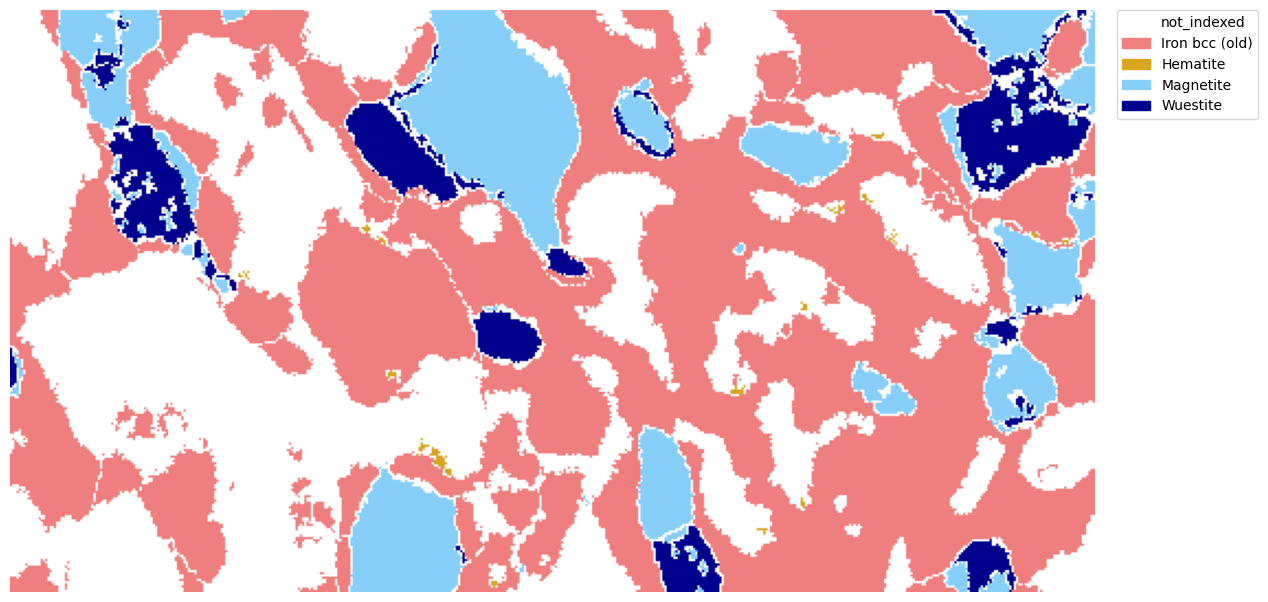

In [7]:
# Custom phase colors
phase_colors = {
    -1: [1, 1, 1],       # not_indexed
     1: [0.94, 0.5, 0.5],      # Iron bcc (old)
     3: [0.85, 0.65, 0.13],    # Hematite
     4: [0.53, 0.81, 0.98],    # Magnetite
     5: [0, 0, 0.55]           # Wuestite
}

phase_labels = {
    -1: 'not_indexed',
     1: 'Iron bcc (old)',
     3: 'Hematite',
     4: 'Magnetite',
     5: 'Wuestite'
}
plot_phase_map_roi(df_sorted, None, None,phase_colors, phase_labels, (14,9), True, None)

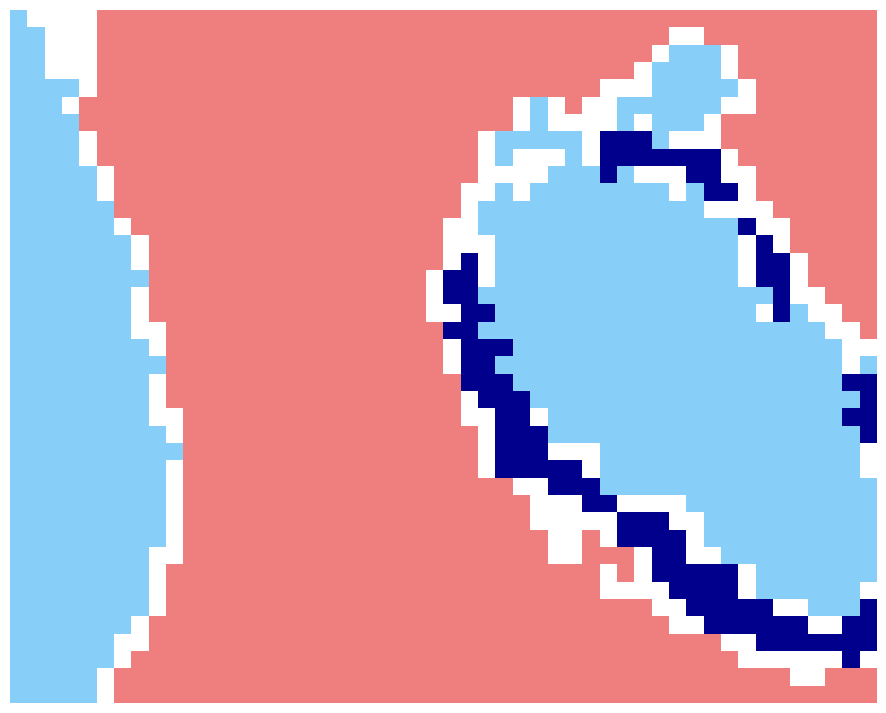

In [23]:
roi_xrange = (250,300)
roi_yrange = (30,70)
plot_phase_map_roi(df_sorted, roi_xrange, roi_yrange, phase_colors, phase_labels, (14,9), False, "phase_map_roi1.png")

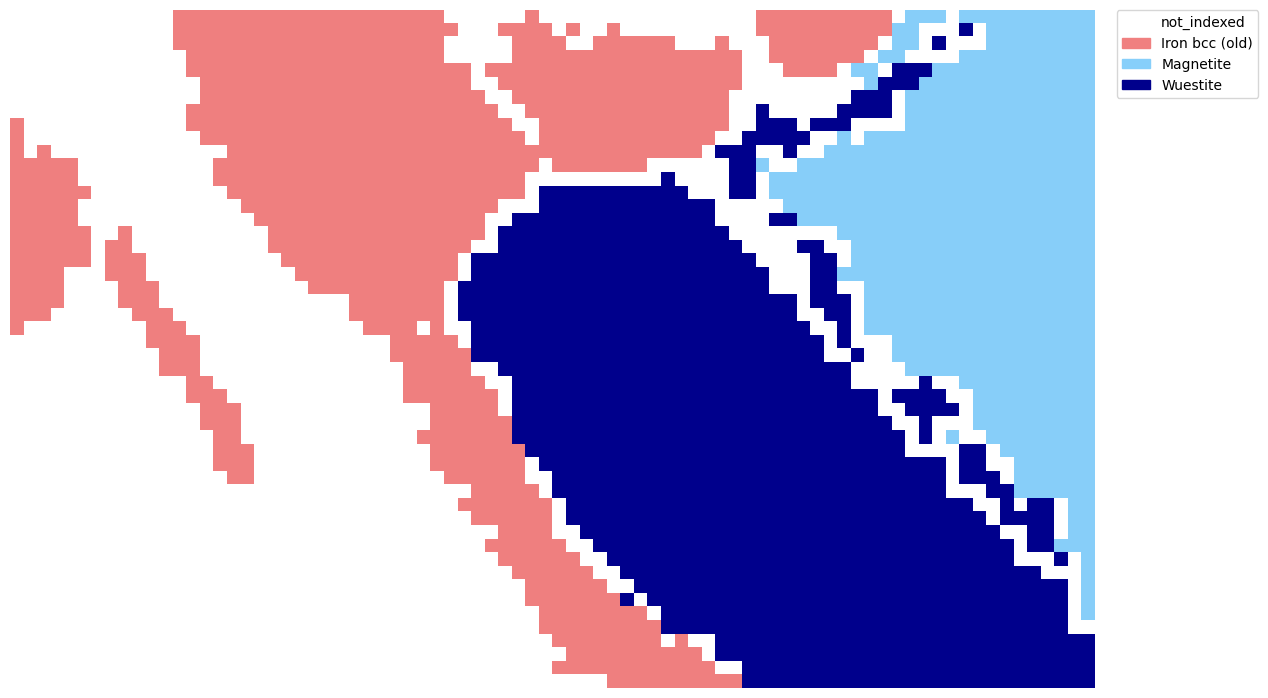

In [11]:
roi_xrange = (120,200)
roi_yrange = (30,80)
plot_phase_map_roi(df_sorted, roi_xrange, roi_yrange, phase_colors, phase_labels, (14,9), True, None)

### 1.4 Phase Boundary detection 
* the phase boundary points are regarded as the points (including points unindexed)surrouded by at least two phases;
* exception for the points on the border with unindexed ones and surrounded only one phase

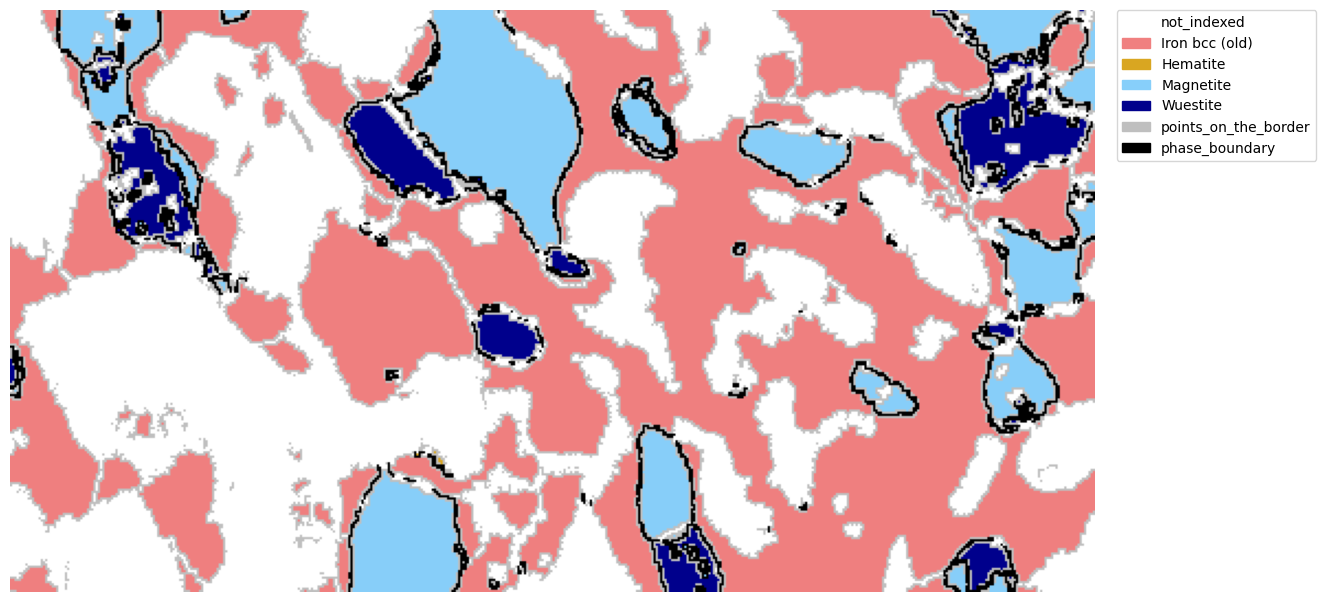

In [8]:
df_new = mark_phase_boundaries_and_plot(df_sorted, None, None, phase_colors, phase_labels, (14,10))

In [9]:
df_new

,x,x_indice,y,y_indice,phase_id,phase_name,eul1,eul2,eul3,phase_boundary,points_on_the_border
0,0.0000,0,0.0000,0,-1,not_indexed,NaN,NaN,NaN,False,False
1,0.0263,1,0.0000,0,-1,not_indexed,NaN,NaN,NaN,False,False
2,0.0525,2,0.0000,0,-1,not_indexed,NaN,NaN,NaN,False,False
3,0.0788,3,0.0000,0,-1,not_indexed,NaN,NaN,NaN,False,False
4,0.1051,4,0.0000,0,-1,not_indexed,NaN,NaN,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...
131665,12.8728,490,6.9618,265,-1,not_indexed,NaN,NaN,NaN,False,False
131666,12.8991,491,6.9618,265,-1,not_indexed,NaN,NaN,NaN,False,False
131667,12.9254,492,6.9618,265,-1,not_indexed,NaN,NaN,NaN,False,False
131668,12.9516,493,6.9618,265,-1,not_indexed,NaN,NaN,NaN,False,False


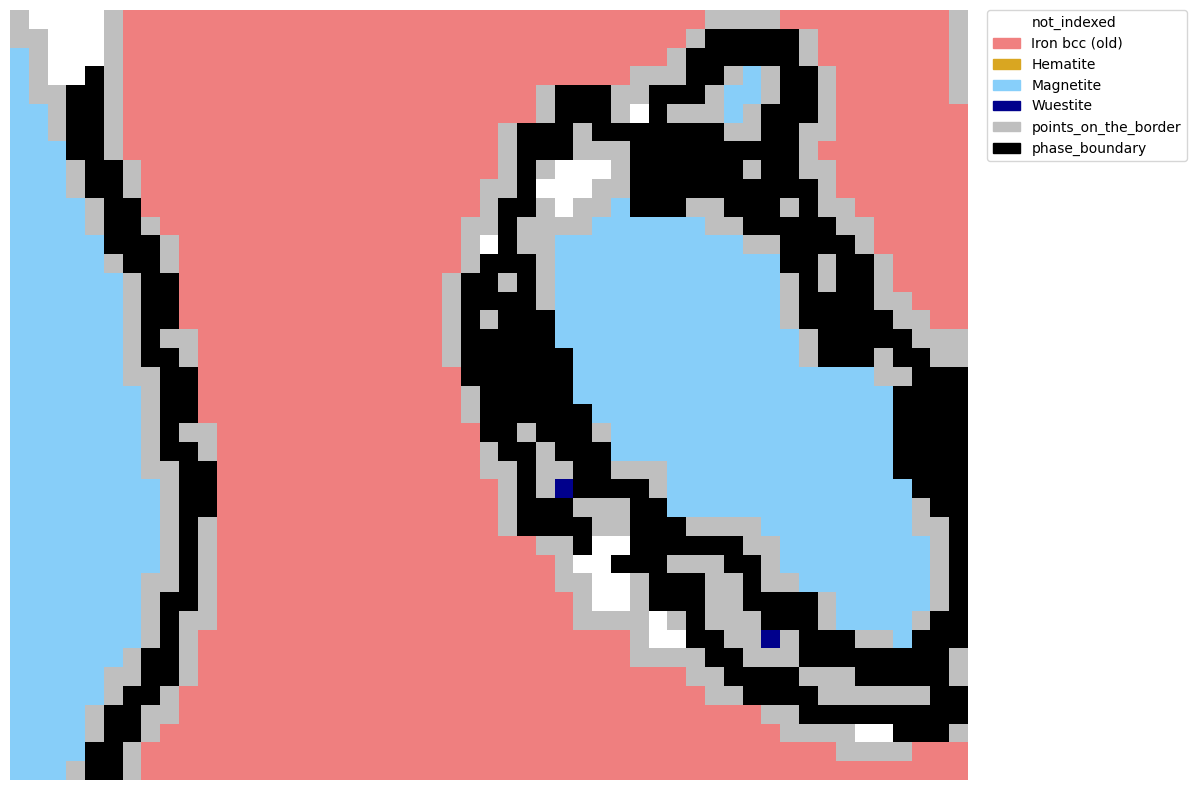

,x,x_indice,y,y_indice,phase_id,phase_name,eul1,eul2,eul3,phase_boundary,points_on_the_border
0,0.0000,0,0.0000,0,-1,not_indexed,NaN,NaN,NaN,False,False
1,0.0263,1,0.0000,0,-1,not_indexed,NaN,NaN,NaN,False,False
2,0.0525,2,0.0000,0,-1,not_indexed,NaN,NaN,NaN,False,False
3,0.0788,3,0.0000,0,-1,not_indexed,NaN,NaN,NaN,False,False
4,0.1051,4,0.0000,0,-1,not_indexed,NaN,NaN,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...
131665,12.8728,490,6.9618,265,-1,not_indexed,NaN,NaN,NaN,False,False
131666,12.8991,491,6.9618,265,-1,not_indexed,NaN,NaN,NaN,False,False
131667,12.9254,492,6.9618,265,-1,not_indexed,NaN,NaN,NaN,False,False
131668,12.9516,493,6.9618,265,-1,not_indexed,NaN,NaN,NaN,False,False


In [9]:
roi_xrange = (250,300)
roi_yrange = (30,70)
mark_phase_boundaries_and_plot(df_sorted, roi_xrange, roi_yrange, phase_colors, phase_labels, (14,10))

In [15]:
def nearest_border_for_boundary(
    df, roi_xrange=None, roi_yrange=None
):
    """
    For points marked phase_boundary=True in the ROI, find the nearest
    points_on_the_border=True (in the same ROI).

    Prints results and returns arrays:
      boundary_x, boundary_y, nearest_x, nearest_y, distances
    """
    # ROI bounds
    if roi_xrange is None:
        xmin, xmax = int(df['x_indice'].min()), int(df['x_indice'].max())
    else:
        xmin, xmax = map(int, roi_xrange)
    if roi_yrange is None:
        ymin, ymax = int(df['y_indice'].min()), int(df['y_indice'].max())
    else:
        ymin, ymax = map(int, roi_yrange)

    in_roi = (
        df['x_indice'].between(xmin, xmax) &
        df['y_indice'].between(ymin, ymax)
    )
    df_roi = df.loc[in_roi]

    A = df_roi.loc[df_roi['phase_boundary'] == True, ['x_indice','y_indice']].to_numpy(float)
    B = df_roi.loc[df_roi['points_on_the_border'] == True, ['x_indice','y_indice']].to_numpy(float)

    if A.size == 0 or B.size == 0:
        print("No boundary or border points in this ROI.")
        return np.array([]), np.array([]), np.array([]), np.array([]), np.array([])

    # Compute pairwise distances
    a2 = np.sum(A*A, axis=1, keepdims=True)        # (Na,1)
    b2 = np.sum(B*B, axis=1, keepdims=True).T      # (1,Nb)
    dot = A @ B.T
    d2  = a2 + b2 - 2*dot
    d2  = np.maximum(d2, 0)
    nn_idx = np.argmin(d2, axis=1)
    dist  = np.sqrt(d2[np.arange(len(A)), nn_idx])

    nearest = B[nn_idx]

    # Print results
    for (bx, by), (nx, ny), d in zip(A.astype(int), nearest.astype(int), dist):
        print(f"Boundary ({bx},{by}) → Nearest border ({nx},{ny}), dist={d:.2f}")

    return (
        A[:,0].astype(int),  # boundary_x
        A[:,1].astype(int),  # boundary_y
        nearest[:,0].astype(int),  # nearest_x
        nearest[:,1].astype(int),  # nearest_y
        dist
    )
    
couple_boundary_border = nearest_border_for_boundary(df_new, roi_xrange, roi_yrange)

Boundary (287,31) → Nearest border (287,30), dist=1.00
Boundary (288,31) → Nearest border (288,30), dist=1.00
Boundary (289,31) → Nearest border (289,30), dist=1.00
Boundary (290,31) → Nearest border (290,30), dist=1.00
Boundary (291,31) → Nearest border (292,31), dist=1.00
Boundary (286,32) → Nearest border (286,31), dist=1.00
Boundary (287,32) → Nearest border (286,31), dist=1.41
Boundary (288,32) → Nearest border (288,33), dist=1.00
Boundary (289,32) → Nearest border (288,33), dist=1.41
Boundary (290,32) → Nearest border (290,33), dist=1.00
Boundary (291,32) → Nearest border (292,32), dist=1.00
Boundary (254,33) → Nearest border (255,33), dist=1.00
Boundary (286,33) → Nearest border (285,33), dist=1.00
Boundary (287,33) → Nearest border (288,33), dist=1.00
Boundary (291,33) → Nearest border (290,33), dist=1.00
Boundary (292,33) → Nearest border (292,32), dist=1.00
Boundary (253,34) → Nearest border (252,34), dist=1.00
Boundary (254,34) → Nearest border (255,34), dist=1.00
Boundary (

In [17]:
ba = df_new["phase_boundary"].astype(bool).to_numpy()
bord_a = df_new["points_on_the_border"].astype(bool).to_numpy()
df_read = pd.read_csv("ebsd_20min_with_boundary_information.csv")
bb = df_read["phase_boundary"].astype(bool).to_numpy()
bord_b = df_read['boundary_not_indexed'].astype(bool).to_numpy()
# --- primary comparison: boundary vs boundary ---
diff_primary = np.where(ba != bb)[0]
print("Boundary vs Boundary:")
print("Same:", (ba == bb).sum(), "Different:", len(diff_primary))
print("First few different indices:", diff_primary[:10])

# --- combined comparison: (boundary OR border) vs other boundary ---
comb_a = ba | bord_a
comb_b = bb | bord_b
diff_comb = np.where(comb_a != comb_b)[0]
print("\n(Boundary OR Border) vs Other Boundary:")
print("Same:", (comb_a == comb_b).sum(), "Different:", len(diff_comb))
print("First few different indices:", diff_comb[:10])

Boundary vs Boundary:
Same: 127457 Different: 4213
First few different indices: [ 22  67  96 108 222 420 428 517 562 563]

(Boundary OR Border) vs Other Boundary:
Same: 124522 Different: 7148
First few different indices: [ 22  46  50  67  96 106 108 220 222 224]


### 1.5 Grain Misorientation and Boundary

In [10]:
ebsd_processed.phases[1].space_group = 229
ebsd_processed.phases[3].space_group = 167
ebsd_processed.phases[4].space_group = 227
ebsd_processed.phases[5].space_group = 225

In [11]:
print(f"Total points: {len(ebsd_processed.phase_id)}")
print(f"Reported shape: {ebsd_processed.shape}")
print(f"Calculated shape: ({len(ebsd_processed.phase_id)/ebsd_processed.shape[1]}, {ebsd_processed.shape[1]})")

Total points: 131670
Reported shape: (266, 494)
Calculated shape: (266.53846153846155, 494)


In [12]:
from orix.quaternion.symmetry import get_point_group

phase_symmetry_dict = {
    1: get_point_group(229),   # Iron bcc
    3: get_point_group(167),     # Hematite
    4: get_point_group(227),    # Magnetite
    5: get_point_group(225)     # Wuestite
}

# Compute KAM and GB maps
kam_map, max_mis_map, gb_maps, result_df = compute_kam_gb_from_df(
    df=df_new,
    phase_symmetry_dict=phase_symmetry_dict,
    ny=266, 
    nx=495,
    kernel_radius=1,
    kam_tolerance=30.0,
    gb_thresholds=[0.1,0.2,0.5,1.0,2.0, 5.0, 10.0],  # Multiple thresholds
    include_phase_boundaries=True
)

# View results
print(result_df.head())

        x  x_indice    y  y_indice  phase_id   phase_name  eul1  eul2  eul3  \
0  0.0000         0  0.0         0        -1  not_indexed   NaN   NaN   NaN   
1  0.0263         1  0.0         0        -1  not_indexed   NaN   NaN   NaN   
2  0.0525         2  0.0         0        -1  not_indexed   NaN   NaN   NaN   
3  0.0788         3  0.0         0        -1  not_indexed   NaN   NaN   NaN   
4  0.1051         4  0.0         0        -1  not_indexed   NaN   NaN   NaN   

   phase_boundary  points_on_the_border  KAM  max_misorientation  GB_0.1  \
0           False                 False  NaN                 NaN   False   
1           False                 False  NaN                 NaN   False   
2           False                 False  NaN                 NaN   False   
3           False                 False  NaN                 NaN   False   
4           False                 False  NaN                 NaN   False   

   GB_0.2  GB_0.5   GB_1   GB_2   GB_5  GB_10  
0   False   False  F

In [25]:
result_df['max_misorientation'].max()

59.93335583435951

In [26]:
# Count grain boundary points by threshold
print("Grain boundary statistics:")
for col in result_df.columns:
    if col.startswith('GB_'):
        count = result_df[col].sum()
        total = len(result_df[result_df['phase_id'] != -1])  # Only indexed points
        percentage = count / total * 100
        print(f"{col}: {count} points ({percentage:.1f}% of indexed area)")

Grain boundary statistics:
GB_1: 3871 points (4.8% of indexed area)
GB_2: 2331 points (2.9% of indexed area)
GB_5: 1600 points (2.0% of indexed area)
GB_10: 1393 points (1.7% of indexed area)


In [28]:
# Count grain boundary points
gb_count = result_df['GB_2'].sum()
total_points = len(result_df)
gb_percentage = gb_count / total_points * 100

print(f"Grain boundary points: {gb_count} of {total_points} ({gb_percentage:.2f}%)")

# Breakdown by phase
if 'phase_name' in result_df.columns:
    gb_by_phase = result_df[result_df['GB_5']].groupby('phase_name').size()
    print("\nGrain boundaries by phase:")
    print(gb_by_phase)

Grain boundary points: 2331 of 131670 (1.77%)

Grain boundaries by phase:
phase_name
Hematite           31
Iron bcc (old)    659
Magnetite         486
Wuestite          424
dtype: int64


### 1.6 KAM map

In [4]:
roi_xrange = (250,300)
roi_yrange = (30,70)
result_df = pd.read_csv("ebsd_processed_with_grain_boundary.csv")

In [5]:
result_df

,x,x_indice,y,y_indice,phase_id,phase_name,eul1,eul2,eul3,phase_boundary,points_on_the_border,KAM,max_misorientation,GB_0.1,GB_0.2,GB_0.5,GB_1,GB_2,GB_5,GB_10
0,0.0000,0,0.0000,0,-1,not_indexed,NaN,NaN,NaN,False,False,NaN,NaN,False,False,False,False,False,False,False
1,0.0263,1,0.0000,0,-1,not_indexed,NaN,NaN,NaN,False,False,NaN,NaN,False,False,False,False,False,False,False
2,0.0525,2,0.0000,0,-1,not_indexed,NaN,NaN,NaN,False,False,NaN,NaN,False,False,False,False,False,False,False
3,0.0788,3,0.0000,0,-1,not_indexed,NaN,NaN,NaN,False,False,NaN,NaN,False,False,False,False,False,False,False
4,0.1051,4,0.0000,0,-1,not_indexed,NaN,NaN,NaN,False,False,NaN,NaN,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131665,12.8728,490,6.9618,265,-1,not_indexed,NaN,NaN,NaN,False,False,NaN,NaN,False,False,False,False,False,False,False
131666,12.8991,491,6.9618,265,-1,not_indexed,NaN,NaN,NaN,False,False,NaN,NaN,False,False,False,False,False,False,False
131667,12.9254,492,6.9618,265,-1,not_indexed,NaN,NaN,NaN,False,False,NaN,NaN,False,False,False,False,False,False,False
131668,12.9516,493,6.9618,265,-1,not_indexed,NaN,NaN,NaN,False,False,NaN,NaN,False,False,False,False,False,False,False


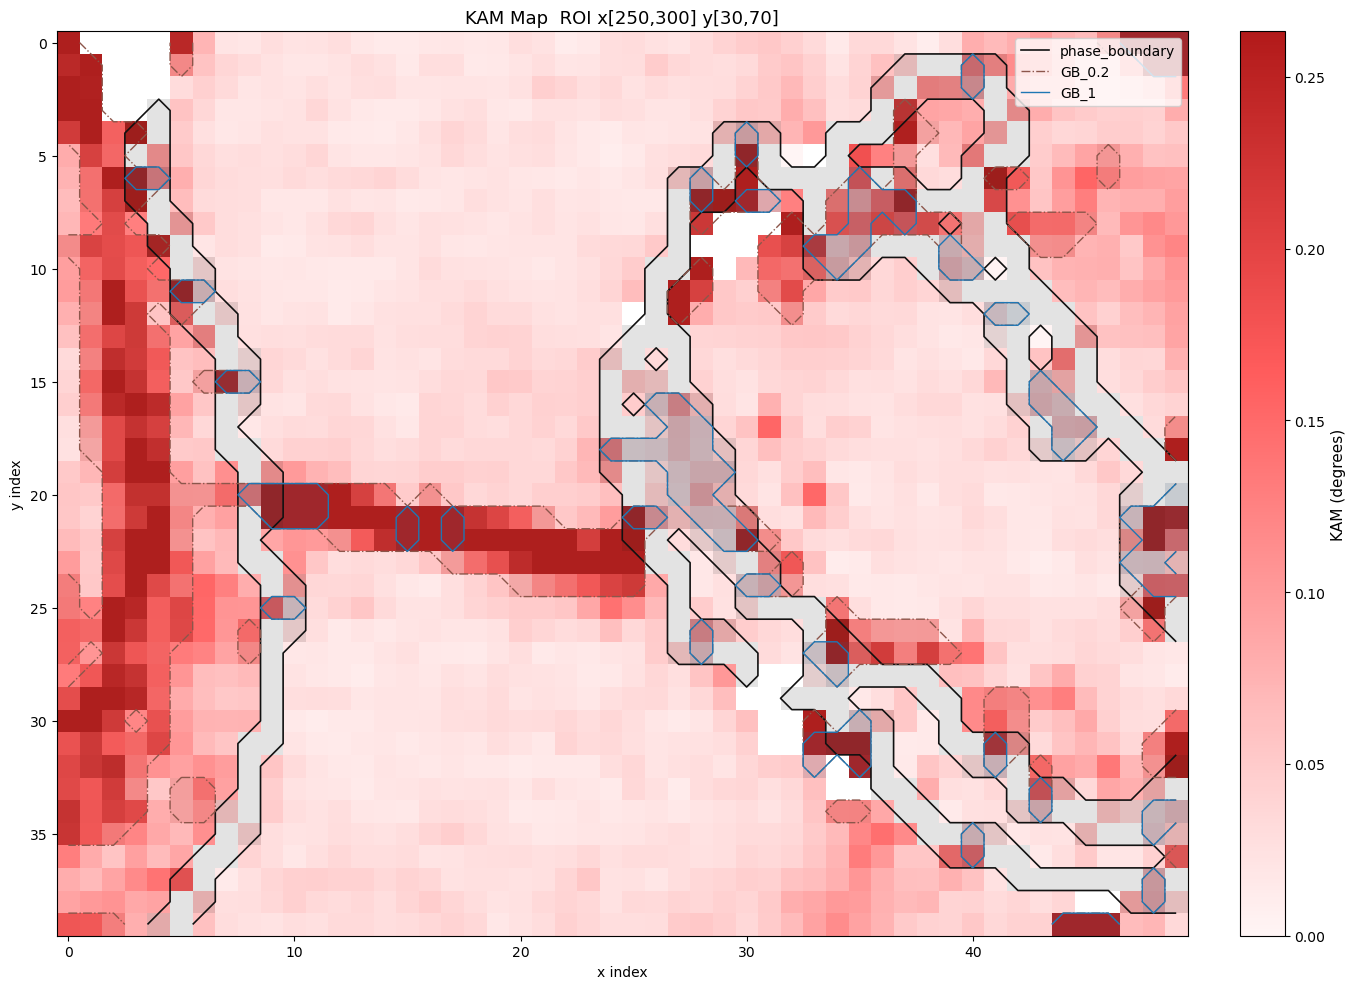

In [6]:
plot_kam_with_overlays(result_df, ny=266, nx=495, roi_xrange=roi_xrange, roi_yrange=roi_yrange, overlays=("phase_boundary", "GB_0.2","GB_1"), fill_overlays=True,figsize=(14,10))

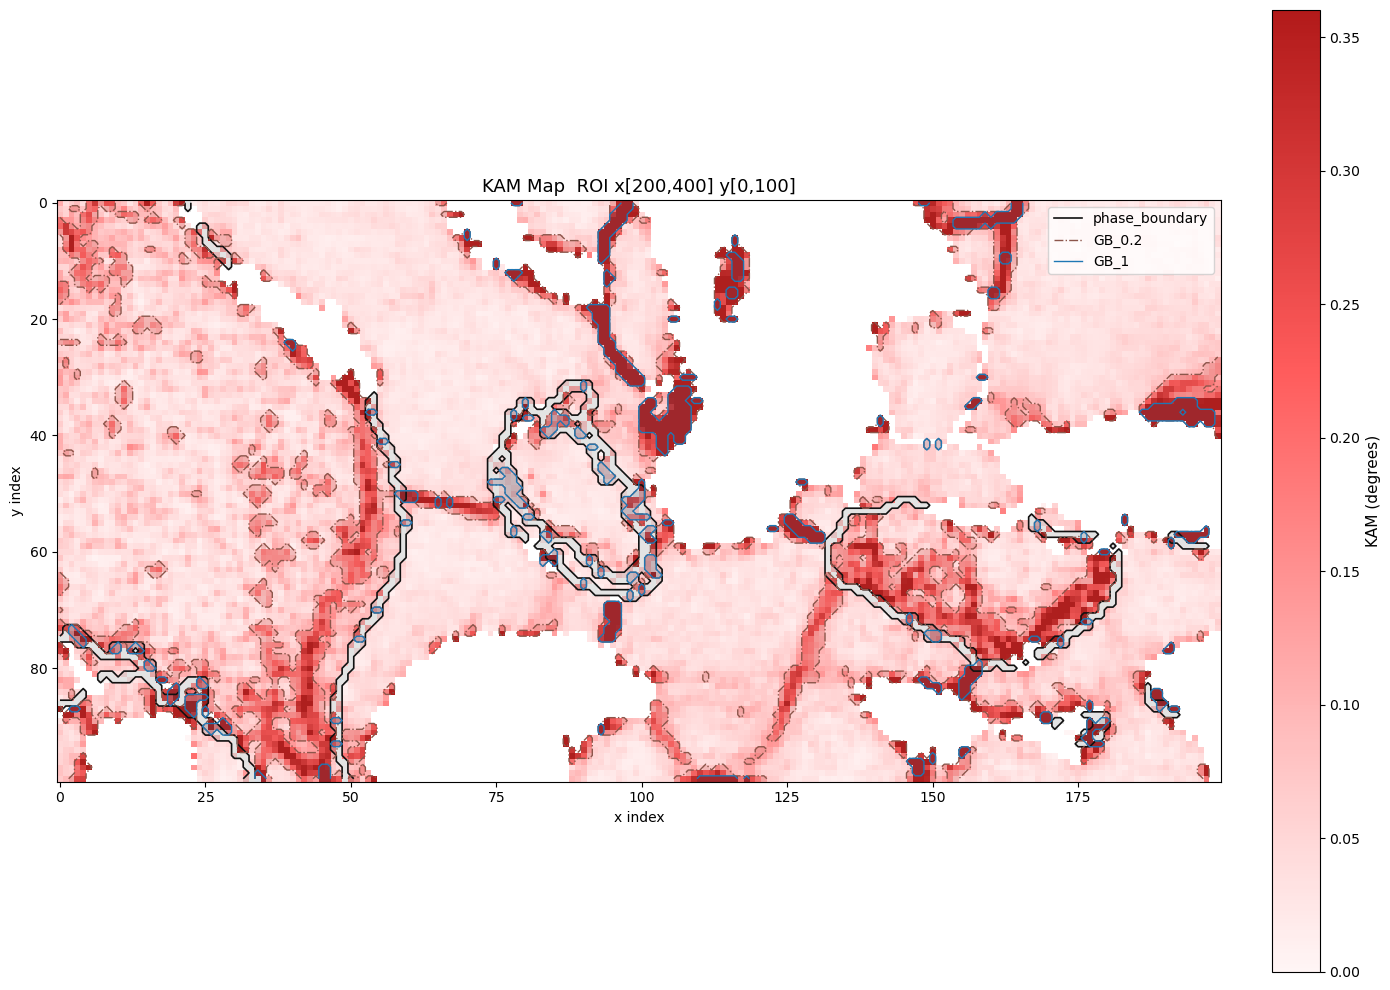

In [7]:
roi_xrange = (200,400)
roi_yrange = (0,100)
plot_kam_with_overlays(result_df, ny=266, nx=495, roi_xrange=roi_xrange, roi_yrange=roi_yrange, overlays=("phase_boundary", "GB_0.2","GB_1"), fill_overlays=True,figsize=(14,10))

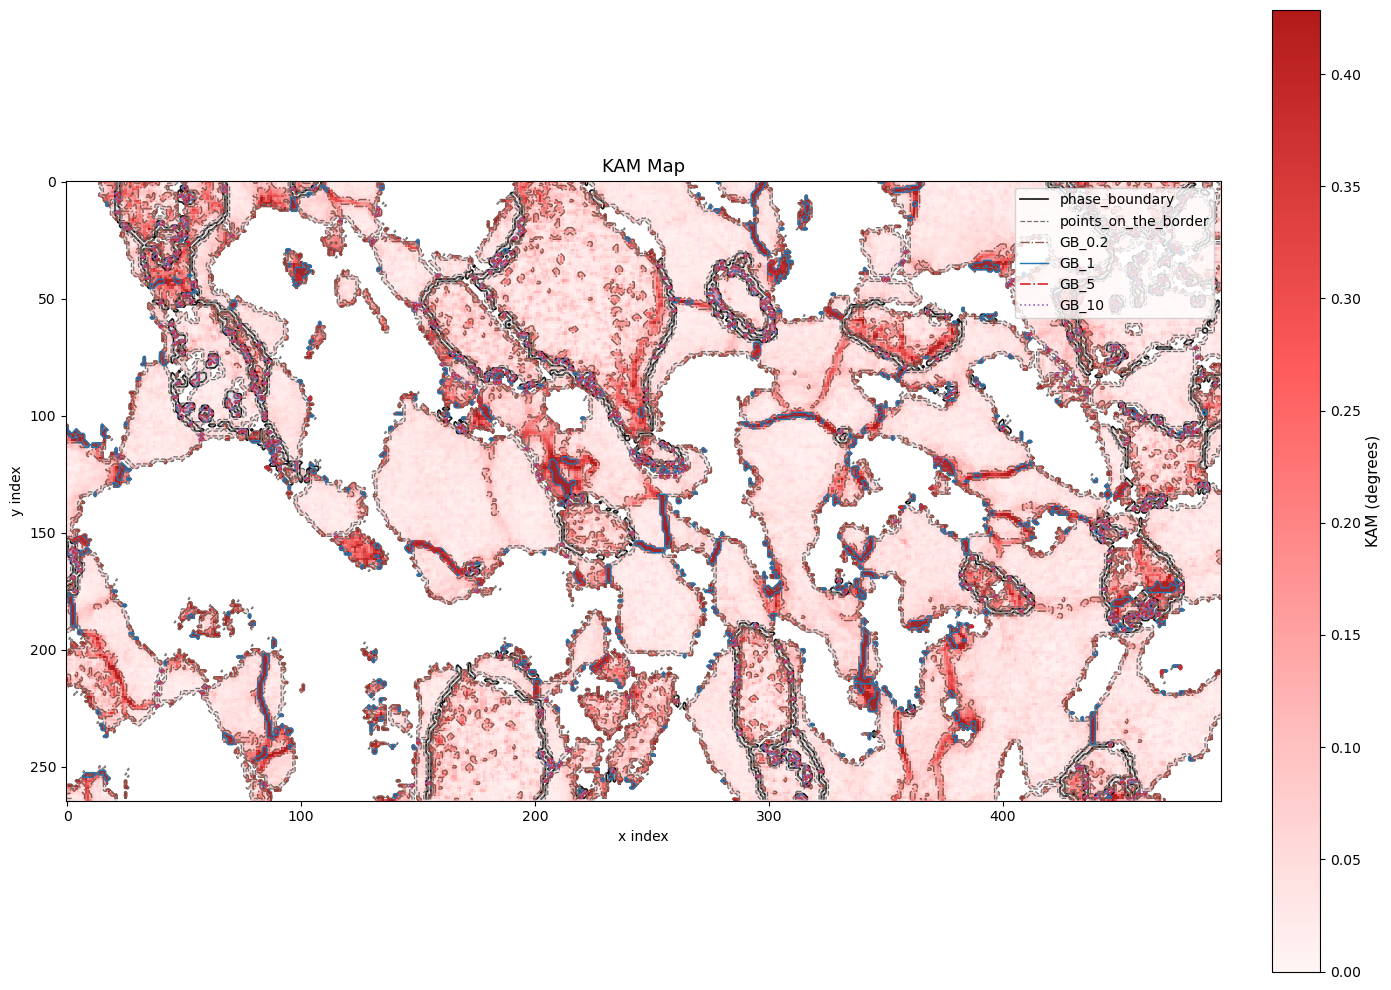

In [21]:
plot_kam_with_overlays(result_df, ny=266, nx=495,roi_xrange=None, roi_yrange=None, overlays=("phase_boundary", "points_on_the_border", "GB_0.2","GB_1","GB_5","GB_10"), fill_overlays=True,figsize=(14,10))

In [22]:
result_df.to_csv('ebsd_processed_with_grain_boundary.csv',index=False)

### 1.6 IPF map